<a href="https://colab.research.google.com/github/ekinfergan/Thesis_Jupyter_Final/blob/main/src/models/mc_lstm_score_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Channel LSTM

In [1]:
!git clone https://github.com/ekinfergan/Thesis_Jupyter_Final.git

Cloning into 'Thesis_Jupyter_Final'...
remote: Enumerating objects: 879, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 879 (delta 132), reused 295 (delta 128), pack-reused 580
Receiving objects: 100% (879/879), 189.03 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (450/450), done.
Updating files: 100% (82/82), done.


In [2]:
%cd Thesis_Jupyter_Final
!git pull
%cd ..

/content/Thesis_Jupyter_Final
Already up to date.
/content


In [3]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.6.9 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.2.1 requires jax>=0.4.8, but you have jax 0.3.25 which is incompatible.


In [4]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-wt9xbtmg
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-wt9xbtmg
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-23.5.9-py3-none-any.whl (17 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100250 sha256=a977b3c111f98e517f8e0d074fd47ac033b6882ab78189c1245077e2ae974072
  Stored in directory: /tmp/pip-ephem-wheel-cache-moi5bpos/wheels/2f/f0/ed/db529a96372d05bd34f6c3a2fa7c08ef7a8314315ac46e49d7
Successfully built scikit-optimize


In [55]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle
from numpy import asarray

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, concatenate, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop, Adagrad

import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import backend as K

In [57]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
# just checkıng gpu ıs avaılable

try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
except ValueError:
  strategy = tf.distribute.get_strategy()

/bin/bash: nvidia-smi: command not found
Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!
[]


In [58]:
script_dir = os.path.dirname(os.path.abspath('mc_lstm.ipynb'))
data_path = os.path.join(script_dir, 'Thesis_Jupyter_Final/src/')
os.getcwd()
print(data_path)

input_folder_path = os.path.join(data_path, 'input')
processed_folder_path = os.path.join(data_path, 'input/processed/normal')
results_folder_path = "results/LSTM_results"

# Create the folder if it doesn't exist
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)

/content/Thesis_Jupyter_Final/src/


In [59]:
# global variables
# Define a dictionary to map sentiment values to category names
senti_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_categories = list(senti_labels.values())
NUM_of_CLASSES = 3

VOCAB_SIZE = 11395
MAX_SEQ_LEN = 449
EMBEDDING_DIM = 100
NUM_OUTPUT_CLASSES = 3

In [60]:
train = pd.read_csv(os.path.join(processed_folder_path, "train.csv"))
val = pd.read_csv(os.path.join(processed_folder_path, "val.csv"))
test = pd.read_csv(os.path.join(processed_folder_path, "test.csv"))

x_train = train['x']
y_train = train['y']
x_val = val['x']
y_val = val['y']
x_test = test['x']
y_test = test['y']
import pickle

# Load encoded sequences
with open(os.path.join(processed_folder_path, "x_train_encoded.pkl"), "rb") as f:
    x_train_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_val_encoded.pkl"), "rb") as f:
    x_val_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_test_encoded.pkl"), "rb") as f:
    x_test_encoded = pickle.load(f)
print(f"x_train_encoded:\n{x_train_encoded[:5]}\n")

# Load embedding vectors
with open(os.path.join(processed_folder_path, "embedding_matrix.pkl"), "rb") as f:
    w2v_embedding_vectors = pickle.load(f)
print(f"embedding vectors: {w2v_embedding_vectors[10][:5]}...\n")

# Load sentiment scores
with open(os.path.join(processed_folder_path, "x_train_scores_padded.pkl"), "rb") as f:
    x_train_scores = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_val_scores_padded.pkl"), "rb") as f:
    x_val_scores = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_test_scores_padded.pkl"), "rb") as f:
    x_test_scores = pickle.load(f)
print(f"x_train_scores:\n{x_train_scores[:5]}\n")

# Load encoded labels
with open(os.path.join(processed_folder_path, "y_train_encoded.pkl"), "rb") as f:
    y_train_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "y_val_encoded.pkl"), "rb") as f:
    y_val_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "y_test_encoded.pkl"), "rb") as f:
    y_test_encoded = pickle.load(f)
print(f"y_train_encoded:\n{y_train_encoded[:5]}\n")

x_train_encoded:
[[  96  549  929 ...    0    0    0]
 [ 453  240 1125 ...    0    0    0]
 [1260   67  312 ...    0    0    0]
 [ 127 1352 6694 ...    0    0    0]
 [ 529   10   69 ...    0    0    0]]

embedding vectors: [-0.57674998 -0.42304999  0.27188    -0.31986001  0.18842   ]...

x_train_scores:
[[-0.875 -0.5    0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [-0.625  0.125  0.375 ...  0.     0.     0.   ]
 [ 0.     0.25   0.    ...  0.     0.     0.   ]
 [-0.125 -0.25   0.    ...  0.     0.     0.   ]]

y_train_encoded:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]



## Evaluation Functions

In [61]:
def one_hot_encode(y):
    y_encoded = np.zeros((len(y), NUM_of_CLASSES))
    for i, label in enumerate(y):
        y_encoded[i, label - 1] = 1

    return y_encoded

def calculate_classification_report(y, y_pred, labels, target_names):
    report = classification_report(y, y_pred, labels=labels, target_names=target_names)
    print("Classification Report:\n", report)

def plot_confusion_matrix(y_true, y_pred, labels, res_path):
    cnf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=labels)
    mat_disp = mat_disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix')
    plt.savefig(os.path.join(res_path, "confusion_matrix.png"))
    plt.close()

def plot_roc_curve(prob_test_vec, y_test, labels, res_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    labels = labels
    colors = cycle(['limegreen', 'dodgerblue', 'red'])
    for senti, color in zip(range(NUM_of_CLASSES), colors):
        RocCurveDisplay.from_predictions(
            y_test[:, senti],
            prob_test_vec[:, senti],
            name=f"ROC curve for {labels[senti]}",
            color=color,
            ax=ax,
        )
    plt.savefig(os.path.join(res_path, "roc_curve.png"))
    plt.close()

def calculate_roc_auc_score(model, model_name, x_test, y_test, labels, res_path):
    prob_test_vec = model.predict(x_test)

    fpr, tpr, thresholds, auc_score = [], [], [], []
    for _ in range(NUM_of_CLASSES):
        fpr.append(0)
        tpr.append(0)
        thresholds.append(0)
        auc_score.append(0)

    for i in range(NUM_of_CLASSES):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], prob_test_vec[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])

    averaged_auc_score = (sum(auc_score) / NUM_of_CLASSES)

    with open(os.path.join(res_path, f"{model_name}_results.txt"), "a") as f:
        f.write(f"AUC score: {auc_score}\n")
        f.write(f"Averaged AUC score: {averaged_auc_score:.2f}\n")

    plot_roc_curve(prob_test_vec, y_test, labels, res_path=res_path)


def plot_development(history):
    acc =  history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation Loss')
    plt.legend()
    plt.show()

    plt.savefig(os.path.join(results_folder_path, "development_plot.png"))
    plt.close()

def get_results(y_pred, y, x, score, history, model, model_name, params, res_path):
    if not os.path.exists(res_path):
        os.makedirs(res_path)

    # Convert to one hot vectors
    y_classes = np.argmax(y, axis=1) + 1
    y_pred_classes = np.argmax(y_pred, axis=1) + 1

    print(y_pred.shape)
    print(y_classes.shape)
    print(y_pred_classes.shape)

    print(f"Accuracy: {score[1]:.2%}")
    print(f"Loss: {score[0]:.2f}")

    with open(os.path.join(res_path, f"{model_name}_results.txt"), "w") as f:
        f.write(f"*{model_name}\n")
        f.write(f"Optimizer Params: {params}\n\n")

        f.write(f"Accuracy: {score[1]:.2f}%\n")
        f.write(f"Loss: {score[0]:.2f}\n")

        report = calculate_classification_report(y_classes, y_pred_classes, labels=np.unique(y_classes), target_names=senti_categories)
        if report is not None:
            f.write("Classification Report:\n")
            f.write(report)
        else:
            print("Failed to generate classification report")
        f.write("\n")

        plot_confusion_matrix(y_classes, y_pred_classes, senti_categories, res_path)
        plot_development(history)
        #calculate_roc_auc_score(model, model_name, x, y, senti_categories, res_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings_layer (Embedding  (None, 449, 100)         1139500   
 )                                                               
                                                                 
 hidden_layer (LSTM)         (None, 64)                42240     
                                                                 
 output_layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 1,181,935
Trainable params: 42,435
Non-trainable params: 1,139,500
_________________________________________________________________
372/372 [==============================] - 4s 10ms/step - loss: 0.8350 - accuracy: 0.8404
(11899, 3)
(11899,)
(11899,)
Accuracy: 84.04%
Loss: 0.83
Classification Report:
               precision    recall  f1-score   support

    Negative 

/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


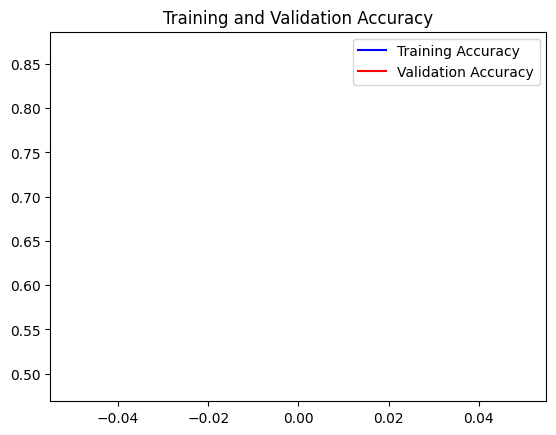

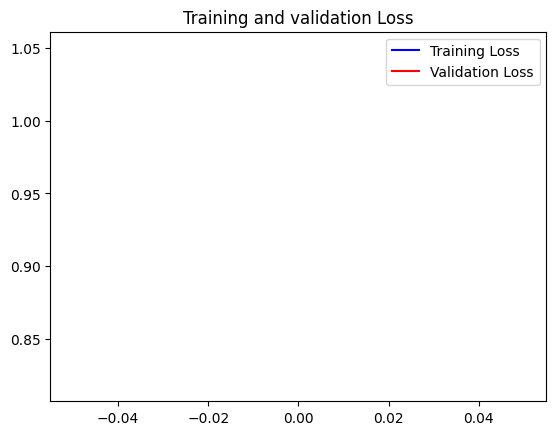

372/372 [==============================] - 3s 7ms/step


In [ ]:
K.clear_session()

model = Sequential()
# input layer is sequence of integers (words)
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, weights=[w2v_embedding_vectors], trainable=False, name="embeddings_layer")) # part of input layer as it transforms integers into dense vectors, input shape = (None, MAX_SEQ_LEN)
model.add(LSTM(64, name='hidden_layer')) # hidden layer
model.add(Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output_layer"))
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

history = model.fit(x_train_encoded, y_train_encoded, validation_data=(x_val_encoded, y_val_encoded), batch_size=16, epochs=1)

y_pred = model.predict(x_test_encoded)
score = model.evaluate(x_test_encoded, y_test_encoded)

get_results(y_pred, y_test_encoded, x_test_encoded, score, history, model, "LSTM", model.optimizer.get_config(), results_folder_path)

del model

K.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
y_classes = np.argmax(y_test_encoded, axis=1) + 1
np.unique(y_classes)

array([1, 2, 3])

In [ ]:
K.clear_session()

model = Sequential()
# input layer is sequence of integers (words)
model.add(Embedding(input_length=MAX_SEQ_LEN,  1, name="embeddings_layer")) # part of input layer as it transforms integers into dense vectors, input shape = (None, MAX_SEQ_LEN)
model.add(LSTM(64, name='hidden_layer')) # hidden layer
model.add(Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output_layer"))
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

history = model.fit(x_train_scores, y_train_encoded, validation_data=(x_val_scores, y_val_encoded), batch_size=16, epochs=2)

y_pred = model.predict(x_test_scores)
score = model.evaluate(x_test_scores, y_test_encoded)

get_results(y_pred, y_test_encoded, x_test_scores, score, history, model, "LSTM", model.optimizer.get_config(), results_folder_path)

del model

K.clear_session()
tf.compat.v1.reset_default_graph()

SyntaxError: positional argument follows keyword argument (3444485417.py, line 5)

In [62]:
K.clear_session()
x_train_scores_exp = np.expand_dims(x_train_scores, axis=-1)
x_val_scores_exp = np.expand_dims(x_val_scores, axis=-1)
x_test_scores_exp = np.expand_dims(x_test_scores, axis=-1)

def define_multi_channel_lstm_model():
     # SentiWordNet scores layer
    inputsA = Input(shape=(MAX_SEQ_LEN, 1), name="input_sentiwordnet_scores")

    # Word2Vec embedding layer
    inputsB = Input(shape=(MAX_SEQ_LEN,), name="input_word2vec_embeddings")
    embeddingsB = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, weights=[w2v_embedding_vectors], trainable=False, name="embeddingsB")(inputsB)

    # Pass both embeddings through their own LSTM layers
    lstm_layersA = LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name='layer_lstmA_1')(inputsA)
    lstm_layersA = LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, name='layer_lstmA_2')(lstm_layersA)

    lstm_layersB = LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name='layer_lstmB_1')(embeddingsB)
    lstm_layersB = LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, name='layer_lstmB_2')(lstm_layersB)


    # Concatenate the two inputs
    merged = concatenate([lstm_layersA, lstm_layersB])

    # Additional Dense layer for dimensionality reduction
    dense_layer = Dense(16, activation='relu', name="dense_layer")(merged)

    # Dense layer for the merged inputs & output Layer
    outputs = Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output")(dense_layer)

    # Create the model
    model = Model(inputs=[inputsA, inputsB], outputs=outputs)

    # Compile the model
    rmsprop = RMSprop(learning_rate=0.001) # default is 0.001
    model.compile(optimizer=rmsprop, loss='mean_squared_error', metrics=['accuracy']) # default learning rate = 0.001
    print(model.summary())

    return model

batch_size = 16
epochs = 20

model = define_multi_channel_lstm_model()

checkpoint_acc = ModelCheckpoint('models/lstm_checkpoint_acc.h5', monitor='val_accuracy', save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint('models/lstm_checkpoint_loss.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)
history = model.fit([x_train_scores_exp, x_train_encoded], y_train_encoded, validation_data=([x_val_scores_exp, x_val_encoded], y_val_encoded), callbacks=[early_stopping, checkpoint_acc, checkpoint_loss, tensorboard_callback], batch_size=batch_size, epochs=epochs, verbose=1)

y_pred = model.predict([x_test_scores_exp, x_test_encoded])
score = model.evaluate([x_test_scores_exp, x_test_encoded], y_test_encoded)

get_results(y_pred, y_test_encoded, x_test_encoded, score, history, model, "LSTM", model.optimizer.get_config(), results_folder_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word2vec_embeddings (Inp  [(None, 449)]       0           []                               
 utLayer)                                                                                         
                                                                                                  
 input_sentiwordnet_scores (Inp  [(None, 449, 1)]    0           []                               
 utLayer)                                                                                         
                                                                                                  
 embeddingsB (Embedding)        (None, 449, 100)     1139500     ['input_word2vec_embeddings[0][0]
                                                                 ']                           

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


  240/41000 [..............................] - ETA: 34:05 - loss: 0.2203 - accuracy: 0.3875

KeyboardInterrupt: ignored

In [ ]:
del model

K.clear_session()
tf.compat.v1.reset_default_graph()

## Hypterparameter Tuning

In [ ]:
batch_size= 16
epochs=30

num_lstm_layersA = Integer(low=1, high=3, name='num_lstm_layersA')
num_lstm_layersB = Integer(low=1, high=3, name='num_lstm_layersB')
num_lstm_unitsA = Categorical([32, 64], name='num_lstm_unitsA')
num_lstm_unitsB = Categorical([32, 64], name='num_lstm_unitsB')
#learning_rate = Categorical([1e-2], name='learning_rate')
#adam_decay = Categorical([1e-6, 1e-4, 1e-2], name="adam_decay")

search_space = [
            num_lstm_layersA,
            num_lstm_layersB,
            num_lstm_unitsA,
            num_lstm_unitsB,
            ]

# Specify one or more initial points for the search of optimal parameter
default_params = [1,
                  1,
                  32,
                  32,
                  ]

In [ ]:
def define_multi_channel_lstm_model(num_lstm_layersA, num_lstm_layersB, num_lstm_unitsA, num_lstm_unitsB):
     # SentiWordNet scores layer
    inputsA = Input(shape=(MAX_SEQ_LEN, 1), name="input sentiwordnet scores")

    # Word2Vec embedding layer
    inputsB = Input(shape=(MAX_SEQ_LEN,), name="input word2vec embeddings")

    # Define an embedding layer for each input
    embeddingsB = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, weights=[w2v_embedding_vectors], trainable=False, name="embeddingsB")(inputsB)

    # Pass both embeddings through their own LSTM layers
    lstm_layersA = inputsA
    for i in range(num_lstm_layersA):
        nameA = 'layer_lstmA_{0}'.format(i+1)
        if i < num_lstm_layersA-1:
            lstm_layersA = LSTM(num_lstm_unitsA, return_sequences=True, name=nameA)(lstm_layersA)
        else:
            lstm_layersA = LSTM(num_lstm_unitsA, return_sequences=False, name=nameA)(lstm_layersA)

    lstm_layersB = embeddingsB
    for i in range(num_lstm_layersB):
        nameA = 'layer_lstmB_{0}'.format(i+1)
        if i < num_lstm_layersB-1:
            lstm_layersB = LSTM(num_lstm_unitsB, return_sequences=True, name=nameA,)(lstm_layersB)
        else:
            lstm_layersB = LSTM(num_lstm_unitsB, return_sequences=False, name=nameA)(lstm_layersB)


    # Concatenate the two inputs
    merged = concatenate([lstm_layersA, lstm_layersB])

    # Additional Dense layer for dimensionality reduction
    dense_layer = Dense(16, activation='relu', name="dense_layer")(merged)

    # Dense layer for the merged inputs & output Layer
    outputs = Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output")(dense_layer)

    # Create the model
    model = Model(inputs=[inputsA, inputsB], outputs=outputs)

    # Compile the model
    rmsprop = RMSprop(learning_rate=0.001) # default is 0.001
    model.compile(optimizer=rmsprop, loss='mean_squared_error', metrics=['accuracy']) # default learning rate = 0.001
    print(model.summary())

    return model

In [ ]:
@use_named_args(dimensions=search_space)
def multi_objective_function(num_lstm_layersA, num_lstm_layersB, num_lstm_unitsA, num_lstm_unitsB):

    model = define_multi_channel_lstm_model(num_lstm_layersA=num_lstm_layersA,
                                            num_lstm_layersB=num_lstm_layersB,
                                            num_lstm_unitsA=num_lstm_unitsA,
                                            num_lstm_unitsB=num_lstm_unitsB,
                                            )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit([x_train_encoded, x_train_encoded],
                        y_train_encoded,
                        validation_data=([x_val_encoded, x_val_encoded], y_val_encoded),
                        epochs=epochs, # TODO
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=2
                        )
    #return the validation accuracy for the last epoch.
    accuracy = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1]

    # Print the classification accuracy.
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Loss: {loss:.2}\n")


    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    # the optimizer aims for the lowest score, so we return our negative accuracy
    return -accuracy

## Gradient Boosted Model

In [ ]:
gbrt_result = gbrt_minimize(func=multi_objective_function,
                            dimensions=search_space,
                            n_calls=12,
                            n_jobs=-1,
                            x0=default_params)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input word2vec embeddings (Inp  [(None, 449)]       0           []                               
 utLayer)                                                                                         
                                                                                                  
 input sentiwordnet scores (Inp  [(None, 449, 1)]    0           []                               
 utLayer)                                                                                         
                                                                                                  
 embeddingsB (Embedding)        (None, 449, 100)     1139500     ['input word2vec embeddings[0][0]
                                                                 ']                           

In [ ]:
# TODO data frame summarizing parameter search
gbrt_best_params = {param.name: value for param, value in zip(gbrt_result.space, gbrt_result.x)}
print("Best Hyperparameters:", gbrt_best_params)

In [ ]:
model = define_multi_channel_lstm_model(gbrt_best_params['num_lstm_layersA'],
                                        gbrt_best_params['num_lstm_layersB'],
                                        gbrt_best_params['num_lstm_unitsA'],
                                        gbrt_best_params['num_lstm_unitsB'],
                                        )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # TODO: should I, again?
history = model.fit([x_train_encoded, x_train_encoded],
                    y_train_encoded,
                    validation_data=([x_val_encoded, x_val_encoded], y_val_encoded),
                    epochs=epochs, # TODO
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=2
                    )
plot_development(history)

In [ ]:
model.evaluate([x_train_scores, x_train_encoded], y_train_encoded)
evaluate_model(model, "Train multi-LSTM", x_train_encoded, y_train_encoded, only_metrics=True)

model.evaluate([x_val_scores, x_val_encoded], y_val_encoded, verbose=0)
evaluate_model(model, "Val multi-LSTM", x_val_encoded, y_val_encoded, only_metrics=True)

model.evaluate([x_test_scores, x_test_encoded], y_test_encoded, verbose=0)
evaluate_model(model, "Test multi-LSTM", x_test_encoded, y_test_encoded, y_test, only_metrics=False)
senti_labels = ['negative', 'neutral', 'positive'] # TODO
#calculate_OvR_roc_auc_score(model, "LSTM", x_train, y_train, x_test, y_test, senti_labels)